# 0. Set up
## 0.1 If if needed, clone Demeter with git

In [1]:
!git clone --branch feature/002-rotation https://github.com/antonfrancois/Demeter_metamorphosis.git

Cloning into 'Demeter_metamorphosis'...
remote: Enumerating objects: 5653, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 5653 (delta 126), reused 153 (delta 91), pack-reused 5441 (from 1)
Receiving objects: 100% (5653/5653), 617.15 MiB | 49.04 MiB/s, done.
Resolving deltas: 100% (3694/3694), done.
Updating files: 100% (176/176), done.


In [6]:
!git pull origin feature/002-rotation

From https://github.com/antonfrancois/Demeter_metamorphosis
 * branch            feature/002-rotation -> FETCH_HEAD
Already up to date.


In [8]:
!git status

fatal: not a git repository (or any of the parent directories): .git


and install the package

In [1]:
import subprocess
import sys, os

cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/


print("\nInstalation of demeter from pip")
!pip install -e .
# !pip install -e .

repo_path = os.path.abspath('.')
# repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)


/content/Demeter_metamorphosis

Instalation of demeter from pip
Obtaining file:///content/Demeter_metamorphosis
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for demeter_metamorphosis (pyproject.toml) ... done
  Created wheel for demeter_metamorphosis: filename=demeter_metamorphosis-0.2.11-0.editable-py3-none-any.whl size=4322 sha256=6726dea6c065cedced15f7dce6e3922e15c54932747fbc54c4cf70aa761eea2f
  Stored in directory: /tmp/pip-ephem-wheel-cache-v4zmmr4x/wheels/c7/71/aa/4dfac81c8e26328effd94ced03987bdc69e149508d2e247f6c
Successfully built demeter_metamorphosis
  Attempting uninstall: demeter_metamorphosis
    Found existing installation: demeter_metamorphosis 0.2.11
    Uninstalling demeter_metamorphosis-0.2.11:
      Successfully uninstalled demeter_metamorphosis-0.2.11
['/content/Demeter_metamorphosis', 

In [2]:
!pip install pynrrd
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0.2 After jupyter restart, run :

In [2]:


import sys
import os


# Remplace par le chemin relatif où se trouve le package 'demeter'
# Exemple : si ton notebook est dans le dossier root du repo, et demeter est un sous-dossier
import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

# repo_path = os.path.abspath('.')
repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)



/content/Demeter_metamorphosis
['/content/Demeter_metamorphosis/', '/content/examples/', '/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/content/Demeter_metamorphosis/src', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython']


# 1. code utile

## imports

In [3]:
import demeter.utils.torchbox as tb
from demeter.constants import *
import demeter.metamorphosis as mt
import demeter.utils.reproducing_kernels as rk
import demeter.utils.rigid_exploration as rg

import sys
import os

# Add the directory containing brats_utils to the Python path
brats_utils_path = os.path.join(os.path.abspath('.'), 'examples/') # Assuming brats_utils is in a 'src' subdirectory
print(brats_utils_path)

if brats_utils_path not in sys.path:
    sys.path.insert(0, brats_utils_path)

import brats_utils as bu

%load_ext autoreload
%autoreload 2
import demeter.metamorphosis.rotate as mtrt
import demeter.utils.axes3dsliders_plt as a3s
from scipy.spatial.transform import Rotation as R

# from ipywidgets import ToggleButton, ToggleButtonStyle
from ipywidgets.widgets.widget_bool import ToggleButtonStyle


# term_width = os.get_terminal_size().columns
term_width = 30


def prepare_momenta(image_shape,
                    image : bool = True,
                    rotation : bool = True,
                    translation : bool = True,
                    rot_prior = None,
                    trans_prior= None,
                    device = "cuda:0",
                    requires_grad = True):
    dim = 2 if len(image_shape) == 4 else 3
    if rot_prior is None:
        rot_prior = torch.zeros((dim,))
    if trans_prior is None:
        trans_prior = [0] * dim
    momenta = {}
    kwargs = {
        "dtype":torch.float32,
        "device":device
    }
    if image:
        momenta["momentum_I"]= torch.zeros(S.shape,**kwargs)
    if rotation:
        if len(rot_prior.shape)==2:
            momenta["momentum_R"] = torch.tensor(rot_prior,**kwargs)
        elif len(rot_prior.shape)==1:
            r1, r2, r3 = rot_prior
            momenta["momentum_R"] = torch.tensor(
            [[0,-r1, -r2 ],
                     [r1, 0, -r3],
                     [r2, r3, 0]],
                    dtype=torch.float32, device='cuda:0')
        else:
            raise ValueError("Rotation prior must be 2 or 1 dimensional")
    if translation:
        momenta["momentum_T"]= torch.tensor(trans_prior,
                                            **kwargs)

    for keys in momenta.keys():
        momenta[keys].requires_grad=requires_grad

    return momenta

def random_affine_def():
    rdm_angle = torch.randn((3,))/4
    rdm_translation = torch.randn((3,))/15

    args_aff = torch.cat(
        [
            rdm_angle,
            rdm_translation,
            torch.ones_like(rdm_angle)
        ], dim = 0
    )
    print(args_aff)

    # args_aff = torch.tensor(
    #         [.6,-.3, 0, # angle
    #         .1,.02,0,   # translation
    #         1,1,1] # scaling
    # )
    aff_mat = tb.create_affine_mat_3d(args_aff)
    print(aff_mat)
    aff_grid = tb.affine_to_grid_3d(aff_mat, img_1.shape[2:])
    return aff_grid, aff_mat


def pixel_to_2square_landmark(landmarks, image_size):
    if len(image_size) > 3:
        image_size = image_size[2:]
    landmarks = landmarks.clone().float()
    for i in range(landmarks.shape[1]):
        landmarks[:,i] *= 2/ (image_size[i] )
    return landmarks - 1

def test_pixel_to_2square_landmark():
    landmarks = torch.tensor(
        [[0,0,0],[240,240,155],[240//2, 240//2, 155//2]]
    )
    img_shape = (1, 1, 240, 240, 155)
    expected_result = torch.tensor([[-1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000],
        [ 0.0000,  0.0000, -0.0065]])
    actual_result = pixel_to_2square_landmark(landmarks, img_shape)
    print('landmarks',landmarks)
    print("landmarks processed",pixel_to_2square_landmark(landmarks,img_shape))
    assert expected_result == actual_result

def apply_aff_to_landmarks(landmarks, grid):
    """
    Transport landmarks by a deformation grid.
    """
    new_land = torch.zeros_like(landmarks)
    for i, l in enumerate(landmarks):
        new_land[i]  = grid[:, int(l[2]), int(l[1]), int(l[0])]            # Bad orient

    return new_land

def inverse_affine(affine):
    """
    Compute the inverse of the affine transformation.
    """
    rot = affine[:3, :3]
    trans = affine[:3, 3][None]
    inv_rot = rot.T
    inv_trans = - trans.T

    new_aff = torch.cat([inv_rot, inv_trans], dim=1)
    return  torch.cat([new_aff, affine[-1][None]], dim=0)

/content/Demeter_metamorphosis/examples/
🔍 Vérification de l'environnement Matplotlib interactif...
❌ ipympl (nécessaire pour `%matplotlib widget`) n'est pas installé.
👉 Exécute : `pip install ipympl` dans une cellule ou un terminal.


# Open raw images


[img_1]
  Normalized img_1 to [0, 1996.912]

[img_2]
  Normalized img_2 to [0, 1442.271]

→ SSD before common normalization: 19794.4277

→ Common max: 1.003
→ img_1 range: [0.000, 1.000]
→ img_2 range: [0.000, 0.998]
→ SSD after common normalization: 19671.1992
torch.Size([6, 3])
torch.Size([1, 1, 192, 192, 124])
torch.Size([1, 1, 192, 192, 124])
landmarks 0 
 tensor([[ 44.8000,  70.4000,  56.0000],
        [ 54.4000, 116.8000,  96.0000],
        [ 63.2000, 120.8000,  96.0000],
        [ 58.4000,  96.8000,  45.6000],
        [ 41.6000,  72.0000,  95.2000],
        [ 36.8000,  84.8000,  85.6000]])
landmarks 1 
 tensor([[ 47.2000,  70.4000,  55.2000],
        [ 54.4000, 116.8000,  97.6000],
        [ 60.8000, 123.2000,  96.0000],
        [ 59.2000,  96.0000,  45.6000],
        [ 41.6000,  72.0000,  96.0000],
        [ 39.2000,  84.8000,  85.6000]])


/content/Demeter_metamorphosis/src/demeter/utils/axes3dsliders_plt.py:321: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  Slider(ax=ax_t, label="t", valmin=0, valmax=T - 1, valinit=T - 1, valfmt="%0.0f", valstep=1),
ic| axes3dsliders_plt.py:640 in _add_lines_on_plt_()
    x: 96
    y: 96
    z: 62


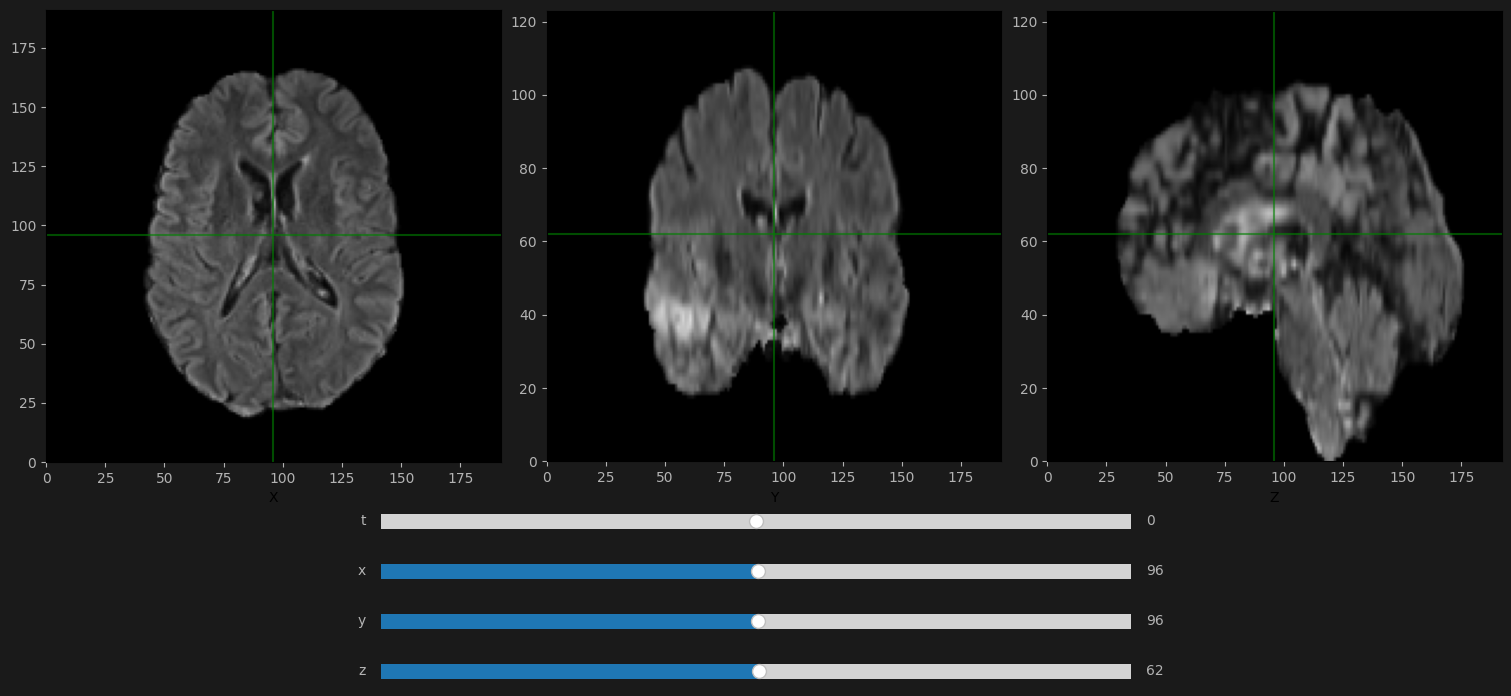

In [4]:
brats_list = [
        # "BraTSReg_086",
        #"BraTSReg_090","BraTSReg_084",
        # "BraTSReg_046",
        # "BraTSReg_002",
    "BraTSReg_021",
    #     "BraTSReg_040",
    # "BraTSReg_118","BraTSReg_114","BraTSReg_132",

        # "BraTSReg_101","BraTSReg_073","BraTSReg_025","BraTSReg_022","BraTSReg_068","BraTSReg_120","BraTSReg_031","BraTSReg_088","BraTSReg_006","BraTSReg_003","BraTSReg_024","BraTSReg_035","BraTSReg_076","BraTSReg_012","BraTSReg_123",
    # 'BraTSReg_034',
    #     'BraTSReg_048',
    # 'BraTSReg_055', 'BraTSReg_082', 'BraTSReg_045', 'BraTSReg_089', 'BraTSReg_057',
        # 'BraTSReg_096', 'BraTSReg_083', 'BraTSReg_042', 'BraTSReg_061', 'BraTSReg_074', 'BraTSReg_097', 'BraTSReg_056', 'BraTSReg_033', 'BraTSReg_136', 'BraTSReg_119', 'BraTSReg_108', 'BraTSReg_054', 'BraTSReg_091', 'BraTSReg_100', 'BraTSReg_030', 'BraTSReg_126', 'BraTSReg_133', 'BraTSReg_138', 'BraTSReg_053', 'BraTSReg_110', 'BraTSReg_079',
    # 'BraTSReg_008', 'BraTSReg_131', 'BraTSReg_001', 'BraTSReg_023', 'BraTSReg_064', 'BraTSReg_067', 'BraTSReg_115', 'BraTSReg_029', 'BraTSReg_093', 'BraTSReg_129', 'BraTSReg_005',
    #  'BraTSReg_140',
        #'BraTSReg_036', 'BraTSReg_071'
    ]


device = 'cuda:0'
valid = False
brats_folder= '2022_valid' if valid else '2022_train'
modality = 'flair'
pb = bu.parse_brats(brats_list=brats_list,brats_folder=brats_folder,modality=modality)
save_folder = None
scale_img = .8

i = 0
img_1,img_2,seg_1,seg_2,landmarks = pb(i,to_torch=True,scale=scale_img,modality=modality)
img_1, img_2 = bu.normalize_mri_with_gliomas(img_1, img_2, seg_1, seg_2, verbose=True)
# img_1 = torch.nn.functional.pad(img_1,(0,0,10,20,0,0), "constant",.5)
print(landmarks[0].shape)
print(img_1.shape)
print(img_2.shape)
# land_2square =  pixel_to_2square_landmark(landmarks[0], img_1.shape)
# ic(landmarks,land_2square)
land_1, land_2 = landmarks
# land_1 =  land_0 +5
print("landmarks 0 \n",land_1)
print("landmarks 1 \n", land_2)
id_grid = tb.make_regular_grid( img_1.shape[2:])

ias = a3s.Image3dAxes_slider(img_1)
plt.show()

# Classical Metamorphosis for tuning

In [ ]:
# RIGID

# RIGID


In [5]:
torch.manual_seed(0)
grid, affine = random_affine_def()

# param = torch.tensor([
#     0,0,torch.pi/3,
#     0,0,0,
#     1,1,1
# ])
# affine = tb.create_affine_mat_3d(param)
# grid = tb.affine_to_grid_3d(affine, img_1.shape[2:])
inv_aff = inverse_affine(affine)
inv_grid = tb.affine_to_grid_3d(inv_aff, img_1.shape[2:])

img_1_aff = tb.imgDeform(img_1, grid  )

inv_grid = tb.square2_to_pixel_convention(inv_grid,True)
land_1_aff = apply_aff_to_landmarks(land_1, inv_grid)



print("land_0_aff", land_1_aff)
# a3s.compare_images_with_landmarks(img_1, img_1_aff, land_1, land_1_aff, labels = ["origin", "displaced"])

print("Images ready to be registred")
print("^"*term_width)

source =  img_1_aff.contiguous()
target  = img_2.contiguous()

tensor([ 0.3852, -0.0734, -0.5447,  0.0379, -0.0723, -0.0932,  1.0000,  1.0000,
         1.0000])
tensor([[ 0.9242, -0.2862, -0.2528,  0.0379],
        [ 0.3748,  0.8069,  0.4566, -0.0723],
        [ 0.0733, -0.5168,  0.8530, -0.0932],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
land_0_aff tensor([[ 34.9770, 110.0197,  65.9377],
        [ 57.2091, 122.0205, 117.1360],
        [ 66.4924, 121.2480, 115.4293],
        [ 53.6719, 130.4605,  62.9310],
        [ 34.5277,  92.8129, 101.2950],
        [ 32.3309, 109.8852, 100.2075]])
Images ready to be registred
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


# Apply Metamorphosis  with rigid
## barycentre alignement

In [6]:
print("="*term_width)
print("Barycentre alignement\n")
shape_list = torch.tensor(source.size()[2:])/2
print(source.shape)
print(shape_list)

source_b, target_b, trans_s, trans_t = rg.align_barycentres(source, target, verbose=True)
land_1_b = land_1 - trans_s * shape_list
land_2_b = land_2 - trans_t * shape_list
print(land_1, land_1_b)
print(land_2, land_2_b)
# a3s.compare_images_with_landmarks(source, source_b,
#                                   land_1, land_1_b,
#                                   labels = ["source", "source_barycentred"])
# a3s.compare_images_with_landmarks(target, target_b,land_2, land_2_b,
#                                   labels = ["target", "target_barcentred"])
# a3s.compare_images_with_landmarks(source_b, target_b,
#                                   land_1_b, land_2_b,
#                                   labels = ["source_barycentred", 'target_barcentred'])

Barycentre alignement

torch.Size([1, 1, 192, 192, 124])
tensor([96., 96., 62.])
S compute barycentre : tensor([-0.0497,  0.1425,  0.1899])
T compute barycentre : tensor([-0.0790,  0.1302, -0.0551])
diff :  tensor([-0.0293, -0.0123, -0.2450])
tensor([[ 44.8000,  70.4000,  56.0000],
        [ 54.4000, 116.8000,  96.0000],
        [ 63.2000, 120.8000,  96.0000],
        [ 58.4000,  96.8000,  45.6000],
        [ 41.6000,  72.0000,  95.2000],
        [ 36.8000,  84.8000,  85.6000]]) tensor([[ 49.5667,  56.7201,  44.2270],
        [ 59.1667, 103.1201,  84.2270],
        [ 67.9667, 107.1201,  84.2270],
        [ 63.1667,  83.1201,  33.8270],
        [ 46.3667,  58.3201,  83.4270],
        [ 41.5667,  71.1201,  73.8270]])
tensor([[ 47.2000,  70.4000,  55.2000],
        [ 54.4000, 116.8000,  97.6000],
        [ 60.8000, 123.2000,  96.0000],
        [ 59.2000,  96.0000,  45.6000],
        [ 41.6000,  72.0000,  96.0000],
        [ 39.2000,  84.8000,  85.6000]]) tensor([[ 54.7819,  57.9018,  58.6

## Prepare Metamorphosis optimizer

In [7]:
kernelOperator = rk.GaussianRKHS(sigma=(15,15,15),normalized=False)
datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=1)
# datacost = mt.Rotation_Cost(target_b, mt.Mutual_Information, alpha=1)

mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=0,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
)

dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])


## Rigid Explorator

In [8]:

top_params = rg.initial_exploration(mr,r_step=5, max_output = 5, verbose=True)
print(top_params)

# top_params =  [
#     (torch.tensor(22700.7285), torch.tensor([-3.1416, -0.6283,  1.8850])),
#     (torch.tensor(22830.1152), torch.tensor([ 0.6283, -3.1416,  1.8850])),
# ]

Init search : 1 / 125
dict_keys(['momentum_R'])
	 (tensor(23358.0098), tensor([-3.1416, -3.1416, -3.1416]))
Init search : 2 / 125
dict_keys(['momentum_R'])
	 (tensor(23355.6289), tensor([-3.1416, -3.1416, -1.8850]))
Init search : 3 / 125
dict_keys(['momentum_R'])
	 (tensor(22805.9766), tensor([-3.1416, -3.1416, -0.6283]))
Init search : 4 / 125
dict_keys(['momentum_R'])
	 (tensor(22987.2734), tensor([-3.1416, -3.1416,  0.6283]))
Init search : 5 / 125
dict_keys(['momentum_R'])
	 (tensor(24062.2480), tensor([-3.1416, -3.1416,  1.8850]))
Init search : 6 / 125
dict_keys(['momentum_R'])
	 (tensor(22336.6328), tensor([-3.1416, -1.8850, -3.1416]))
Init search : 7 / 125
dict_keys(['momentum_R'])
	 (tensor(21618.4004), tensor([-3.1416, -1.8850, -1.8850]))
Init search : 8 / 125
dict_keys(['momentum_R'])
	 (tensor(20512.3047), tensor([-3.1416, -1.8850, -0.6283]))
Init search : 9 / 125
dict_keys(['momentum_R'])
	 (tensor(22044.1465), tensor([-3.1416, -1.8850,  0.6283]))
Init search : 10 / 125
dict_

## Optimize Rigid on best values


In [9]:
best_loss, best_momentum, best_translation, best_rot = rg.optimize_on_rigid(mr, top_params, n_iter=10,verbose=True)
rot_def =   tb.apply_rot_mat(mr.mp.id_grid, best_rot.T)

# rot_def -= best_translation
# img_rot = tb.imgDeform(mr.mp.image, rot_def.to('cpu'),
#                        dx_convention='2square', clamp=True)
#
# a3s.compare_images_with_landmarks(img_rot, source_b, land_1_b, land_2_b,
#                                   labels= ["img_rot", "source_b"],)
#
# a3s.compare_images_with_landmarks(img_rot, target_b, land_1_b, land_2_b,
#                                   labels= ["img_rot", "target_b"],)

# best_momentum = torch. tensor([[ 0.0000, -0.4125, -0.1989],
#         [ 0.4125,  0.0000,  0.5446],
#         [ 0.1989, -0.5446,  0.0000]])
# best_translation = torch. tensor([ 0.0037,  0.0205, -0.0379])
# best_rotation = tensor([[ 0.0655,  0.8918,  0.4477],
#         [-0.9973,  0.0430,  0.0602],
#         [ 0.0344, -0.4504,  0.8921]])

>>>>>>>>>>
0/5 Optimize wit params [0.6283185482025146, 0.6283185482025146, -0.6283185482025146]
momenta type <class 'dict'>
momenta keys dict_keys(['momentum_R', 'momentum_T'])


/content/Demeter_metamorphosis/src/demeter/metamorphosis/rotate.py:281: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  momT_translated = momentum_T @ translation.T


Progress: [##--------]  20.00%  (Rotation_Ssd_Cost : ,7612.6323).
Progress: [###-------]  30.00%  (Rotation_Ssd_Cost : ,7612.5098).
Progress: [####------]  40.00%  (Rotation_Ssd_Cost : ,7612.5098).
Progress: [#####-----]  50.00%  (Rotation_Ssd_Cost : ,7612.5098).
Progress: [######----]  60.00%  (Rotation_Ssd_Cost : ,7612.5098).
Progress: [#######---]  70.00%  (Rotation_Ssd_Cost : ,7612.5098).
Progress: [########--]  80.00%  (Rotation_Ssd_Cost : ,7612.5098).
Progress: [#########-]  90.00%  (Rotation_Ssd_Cost : ,7612.5098).
Progress: [##########] 100.00% Done...
 (Rotation_Ssd_Cost : ,7612.5098).

Computation of forward done in  0:00:06s and 0.231cents  s
best = True
tensor([ 0.0053,  0.0206, -0.0394])
tensor([[ 0.9113, -0.3123, -0.2684],
        [ 0.4039,  0.8051,  0.4345],
        [ 0.0804, -0.5043,  0.8598]])
best mom tensor([[ 0.0000, -0.4128, -0.2010],
        [ 0.4128,  0.0000,  0.5411],
        [ 0.2010, -0.5411,  0.0000]])
anti best mom tensor([[ 0.0000, -0.4128, -0.2010],
      

tensor([[ 0.0000, -0.4128, -0.2010],
        [ 0.4128,  0.0000,  0.5411],
        [ 0.2010, -0.5411,  0.0000]], requires_grad=True)
tensor([ 0.0053,  0.0206, -0.0394], requires_grad=True)
dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])
tensor([[ 0.9113, -0.3123, -0.2684],
        [ 0.4039,  0.8051,  0.4345],
        [ 0.0804, -0.5043,  0.8598]], grad_fn=<MmBackward0>)


Text(0.5, 1.0, 'img vs source')

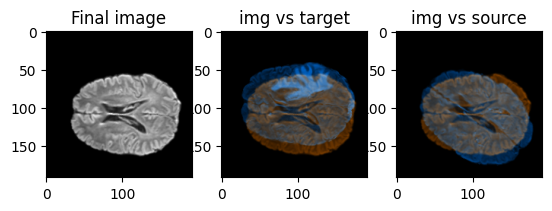

In [10]:
momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    img_1.shape,
    image=False,
    rotation=True,
    translation=True,
    rot_prior=best_momentum.detach().clone(),trans_prior=best_translation.detach().clone(),
    device= "cpu"
)
print(momenta["momentum_R"])
print(momenta["momentum_T"])
kernelOperator = rk.GaussianRKHS(sigma=(10,10,10),normalized=False)
datacost = mt.Rotation_Ssd_Cost(img_1.to('cuda:0'), alpha=.5)
# datacost = mt.Rotation_Cost(target_b, mt.Mutual_Information, alpha=.5)
mr = mt.rigid_along_metamorphosis(
    source, target, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
    n_iter=0,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)
mr.mp.forward(source.cpu(), momenta, save=True)

print(mr.mp.rot_mat)

rot_def =   tb.apply_rot_mat(mr.mp.id_grid,  mr.mp.rot_mat.T)
rot_def += mr.mp.translation
rotated_source = tb.imgDeform(mr.mp.image,rot_def,dx_convention='2square')
img = rotated_source[0,0,..., mr.source.shape[-1]//2].detach().cpu()
img_target = tb.imCmp(rotated_source[..., source.shape[-1]//2].detach().cpu(), mr.target[..., source.shape[-1]//2].detach().cpu(), "compose")[0]
img_source = tb.imCmp(rotated_source[..., source.shape[-1]//2].detach().cpu(), mr.source[..., source.shape[-1]//2].detach().cpu(), "compose")[0]
fig,ax = plt.subplots(1,3)
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Final image")
ax[1].imshow(img_target, cmap="gray")
ax[1].set_title("img vs target")
ax[2].imshow(img_source, cmap="gray")
ax[2].set_title("img vs source")

## Metamorphosis along rigid

Text(0.5, 1.0, 'target')

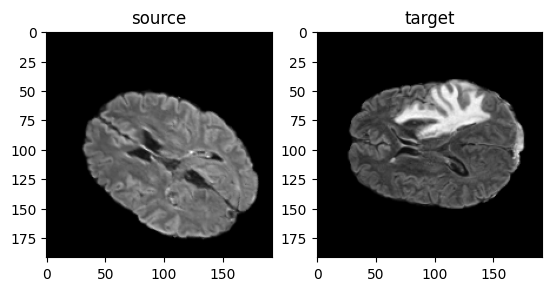

In [11]:
fig, ax = plt.subplots(1,2)
T, _, D, H, W = source.shape

# Choose a central slice for plotting
slice_index = W // 2
ax[0].imshow(source[0,0,..., slice_index], cmap='gray')
ax[0].set_title(f'source')

ax[1].imshow(target[0,0,..., slice_index], cmap='gray')
ax[1].set_title(f'target')

In [20]:
# prompt: empty GPU memory
del mr
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

46016

True
True
True
dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])
momenta type <class 'dict'>
momenta keys dict_keys(['momentum_I', 'momentum_R', 'momentum_T'])
Progress: [#---------]  13.33%  (Rotation_Ssd_Cost : ,12101.2080).
Progress: [##--------]  20.00%  (Rotation_Ssd_Cost : ,11502.1436).
Progress: [###-------]  26.67%  (Rotation_Ssd_Cost : ,10530.0430).
Progress: [###-------]  33.33%  (Rotation_Ssd_Cost : ,9912.5762).
Progress: [####------]  40.00%  (Rotation_Ssd_Cost : ,9012.0527).
Progress: [#####-----]  46.67%  (Rotation_Ssd_Cost : ,8367.2246).
Progress: [#####-----]  53.33%  (Rotation_Ssd_Cost : ,8018.1733).
Progress: [######----]  60.00%  (Rotation_Ssd_Cost : ,7916.1025).
Progress: [#######---]  66.67%  (Rotation_Ssd_Cost : ,7760.2563).
Progress: [#######---]  73.33%  (Rotation_Ssd_Cost : ,7628.2036).
Progress: [########--]  80.00%  (Rotation_Ssd_Cost : ,7147.9268).
Progress: [#####

(<Figure size 1000x1000 with 2 Axes>,
 array([<Axes: title={'center': 'Lambda = 0.1'}>, <Axes: >], dtype=object))

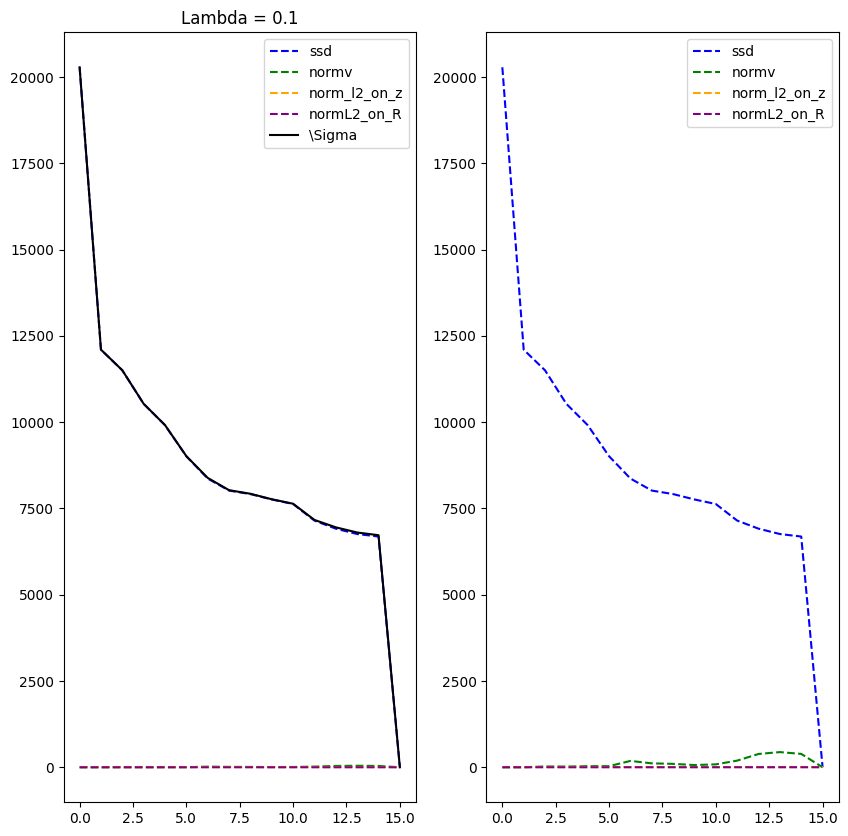

In [12]:
kernelOperator = rk.GaussianRKHS(sigma=(10,10,10),normalized=False)
datacost = mt.Rotation_Ssd_Cost(img_1.to('cuda:0'), alpha=.5)
# datacost = mt.Rotation_MutualInformation_Cost(target_b, alpha=.5)

momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    img_1.shape,
    image=True,
    rotation=True,
    translation=True,
    rot_prior=best_momentum.detach().clone(),trans_prior=best_translation.detach().clone(),
)

for v in momenta.values():
    print(v.requires_grad)

mr = mt.rigid_along_metamorphosis(
    source, target, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
    n_iter=15,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)

# mr = mt.metamorphosis(
#     img_1, img_2, momentum_ini=momenta,
#     kernelOperator= kernelOperator,
#     rho = 1,
#     data_term=datacost ,
#     integration_steps = 10,
#     cost_cst=.1,
#     n_iter=10,
#     grad_coef=1
# )

mr.plot_cost()

# a3s.compare_images_with_landmarks(mr.mp.image, img_1,
#                                   labels= ["Final", "source"],)
# a3s.compare_images_with_landmarks(mr.mp.image, img_2,
#                                   labels= ["Final", "target_b"],)

comparison_img shape (192, 192, 4)
comparison_img shape (192, 192, 4)
comparison_img shape (192, 192, 4)
comparison_img shape (192, 192, 4)
comparison_img shape (192, 192, 4)
comparison_img shape (192, 192, 4)
comparison_img shape (192, 192, 4)
comparison_img shape (192, 192, 4)
comparison_img shape (192, 192, 4)
comparison_img shape (192, 192, 4)


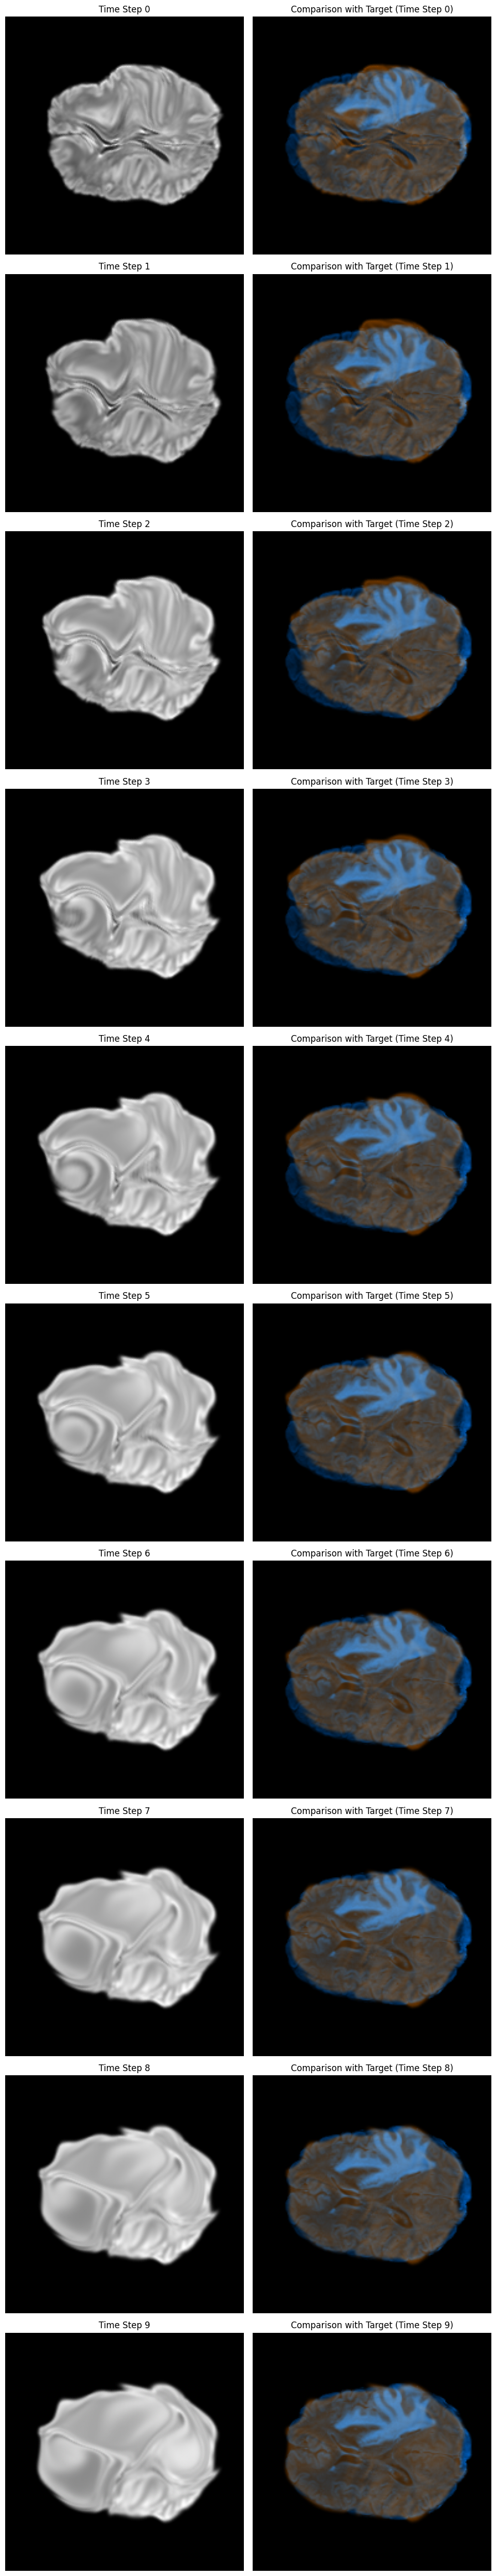

In [13]:
# prompt: Peux tu me faire une figure qui prends les images dans mr.mp.image_stock (tensor de taille [T,1,D,H,W]) et me plotter une coupe pour chaque temps (T) ? Peux tu ajouter une deuxième colonne avec la comparaison avec l'image target (mr.target) en utilisant tb.imgCmp()

import matplotlib.pyplot as plt

def plot_metamorphosis_slices(mr):
    """
    Plots slices of the metamorphosis images at each time step and compares them
    to the target image.

    Args:
        mr: An object representing the metamorphosis process, expected to have
            an attribute mr.mp.image_stock (tensor of shape [T, 1, D, H, W])
            and mr.target (tensor of shape [1, D, H, W]).
    """

    # mr.to_device('cpu')
    image_stock = mr.mp.image_stock.cpu()  # Remove channel dim and move to numpy
    T, _, D, H, W = image_stock.shape

    # apply rotation to target
    rot_def =   tb.apply_rot_mat(mr.mp.id_grid,  mr.mp.rot_mat.T)
    rot_def += mr.mp.translation
    rotated_img_stock = tb.imgDeform(mr.mp.image_stock,rot_def,dx_convention='2square')

    # Choose a central slice for plotting
    slice_index = W // 2

    fig, axes = plt.subplots(T, 2, figsize=(10, T * 5))

    for t in range(T):
        # Plot the metamorphosis image slice
        axes[t, 0].imshow(rotated_img_stock[t,0, :, :,slice_index], cmap='gray')
        axes[t, 0].set_title(f'Time Step {t}')
        axes[t, 0].axis('off')

        # Plot the comparison with the target image using tb.imgCmp
        # tb.imgCmp expects tensors, so convert numpy arrays back to tensors
        img = rotated_img_stock[t, ..., slice_index][None].to("cpu")
        target_tensor = mr.target[..., slice_index].to("cpu") # Get the slice and add batch/channel dims

        comparison_img = tb.imCmp(img, target_tensor, "compose")[0]
        print("comparison_img shape",comparison_img.shape)

        axes[t, 1].imshow(comparison_img, cmap='gray') # Use 'gray' or adjust cmap as needed
        axes[t, 1].set_title(f'Comparison with Target (Time Step {t})')
        axes[t, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'mr' is the metamorphosis object created in the preceding code
plot_metamorphosis_slices(mr)
